
# Hugging Face `pipeline`: Beginner-Friendly Tour (with Zero‑Shot Demos)

**Audience:** 4th‑year CS students — beginner friendly  
**Goal:** Learn how to use 🤗 Transformers **`pipeline`** to run **pretrained** models quickly (no fine‑tuning) and
see where **zero‑shot** pipelines are powerful.

> This follows the spirit of HF LLM Course Chapter 1.3 (Pipelines) and adds gentle explanations, tips, and exercises.



## 0) Setup (Install, Seeds, Device)


In [1]:

# If needed, uncomment to install dependencies:
# %pip install -U transformers torch accelerate sentencepiece sacremoses datasets

import os, random, time
import numpy as np
import torch
from transformers import pipeline

# --- Reproducibility (mostly affects sampling-based generators) ---
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# --- Device selection for pipelines: device=0 means CUDA GPU 0; -1 means CPU ---
device = 0 if torch.cuda.is_available() else -1
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available(), "| pipeline(device) =", device)


/home/kperkins411/anaconda3/envs/ultralytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch: 2.8.0+cu128 | CUDA available: True | pipeline(device) = 0



## 1) What *is* `pipeline`?



`pipeline(task, model=..., tokenizer=...)` is a **high‑level helper** that hides the usual steps:
1. **Tokenize** raw inputs (text → token IDs)  
2. **Run the model** forward pass  
3. **Post‑process** outputs into friendly Python objects (labels, scores, text, etc.)

If you **omit `model=`**, it will pick a sensible default from the Hub for that task.  
You can always **override** with a specific model ID later.



### 1.1 Minimal example: Sentiment Analysis (zero‑shot pretrained)


In [2]:

# Default pretrained model for sentiment analysis (zero-shot use: we don't fine-tune anything here)
sentiment = pipeline("sentiment-analysis", device=device)
result = sentiment("I absolutely love using Transformers—it's so convenient!")
print(result)  # [{'label': 'POSITIVE', 'score': ...}]


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9973852038383484}]



### 1.2 Batch inputs (faster than looped single calls)


In [3]:

texts = [
    "Today is an amazing day 😄",
    "The interface is confusing and slow.",
    "Meh, it's fine but could be better.",
]
for out in sentiment(texts):
    print(out)


{'label': 'POSITIVE', 'score': 0.9998496770858765}
{'label': 'NEGATIVE', 'score': 0.9997743964195251}
{'label': 'POSITIVE', 'score': 0.9863070845603943}



### 1.3 Under the hood
- Picks / loads a **tokenizer** and **model** (from the Hub cache after first download)  
- Handles **padding/truncation** defaults (configurable)  
- Converts logits → **labels/scores**  
- Runs on **GPU** if available, else CPU



## 2) Zero‑Shot Text Classification (No Task‑Specific Training)



**Problem:** Classify a sentence into **labels you choose on the fly** (e.g., `"bug report"`, `"feature request"`), even if the model was **not trained** specifically for those labels.

**How:** Use a Natural Language Inference (NLI) model (e.g., `facebook/bart-large-mnli`) under the hood.  
The pipeline scores how much the text **entails** each label hypothesis (e.g., “This text is about *a bug report*”).


In [4]:

zs = pipeline(
    task="zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device
)

candidate_labels = ["customer support", "bug report", "feature request", "pricing", "complaint"]
text = "The app keeps crashing whenever I try to upload a photo. Please fix it."
zs(text, candidate_labels=candidate_labels)  # labels with probabilities


Device set to use cuda:0


{'sequence': 'The app keeps crashing whenever I try to upload a photo. Please fix it.',
 'labels': ['complaint',
  'bug report',
  'feature request',
  'customer support',
  'pricing'],
 'scores': [0.7030916810035706,
  0.1773611456155777,
  0.09714607894420624,
  0.01991756074130535,
  0.002483520656824112]}


**Batch example:** Pass several texts to save time.


In [5]:

batch_texts = [
    "Could you add SSO with Okta?",
    "My credit card was charged twice.",
    "New release works flawlessly. Kudos to the team!",
]
zs(batch_texts, candidate_labels=candidate_labels)


[{'sequence': 'Could you add SSO with Okta?',
  'labels': ['feature request',
   'complaint',
   'bug report',
   'pricing',
   'customer support'],
  'scores': [0.9558725357055664,
   0.014020157046616077,
   0.012814385816454887,
   0.010811852291226387,
   0.006481096614152193]},
 {'sequence': 'My credit card was charged twice.',
  'labels': ['pricing',
   'complaint',
   'feature request',
   'bug report',
   'customer support'],
  'scores': [0.4105657935142517,
   0.4047938585281372,
   0.08438967168331146,
   0.0738905519247055,
   0.026360081508755684]},
 {'sequence': 'New release works flawlessly. Kudos to the team!',
  'labels': ['customer support',
   'feature request',
   'pricing',
   'bug report',
   'complaint'],
  'scores': [0.3301944136619568,
   0.298556923866272,
   0.15793240070343018,
   0.14598460495471954,
   0.06733157485723495]}]


**Tip:** Ask for **all scores** to see probabilities for every label (useful for multi‑label cases).


In [6]:

zs(text, candidate_labels=candidate_labels, multi_label=True)  # treats labels as independent


{'sequence': 'The app keeps crashing whenever I try to upload a photo. Please fix it.',
 'labels': ['complaint',
  'bug report',
  'feature request',
  'customer support',
  'pricing'],
 'scores': [0.9936656951904297,
  0.9305064678192139,
  0.6948819160461426,
  0.6003645658493042,
  0.0006249631987884641]}


## 3) Masked Language Modeling — `fill-mask` (Pretrained, Zero‑Shot)



Given a sentence with a **mask token**, predict the missing word(s) using a pretrained masked‑LM (`bert-base-uncased`).


In [7]:

fill = pipeline("fill-mask", model="bert-base-uncased", device=device)
fill("Transformers are the most [MASK] library for NLP.")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[{'score': 0.16794109344482422,
  'token': 7721,
  'token_str': 'comprehensive',
  'sequence': 'transformers are the most comprehensive library for nlp.'},
 {'score': 0.13295727968215942,
  'token': 2590,
  'token_str': 'important',
  'sequence': 'transformers are the most important library for nlp.'},
 {'score': 0.11978036165237427,
  'token': 2759,
  'token_str': 'popular',
  'sequence': 'transformers are the most popular library for nlp.'},
 {'score': 0.08493489027023315,
  'token': 4866,
  'token_str': 'extensive',
  'sequence': 'transformers are the most extensive library for nlp.'},
 {'score': 0.0647149607539177,
  'token': 2109,
  'token_str': 'used',
  'sequence': 'transformers are the most used library for nlp.'}]


## 4) Named Entity Recognition (NER) — Token Classification



Extract entities (people, organizations, locations) from text.  
`aggregation_strategy="simple"` merges word‑pieces into full tokens.


In [8]:

ner = pipeline("token-classification", aggregation_strategy="simple", device=device)
ner("Hugging Face is based in Paris and New York, and Google is one of its partners.")


No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[{'entity_group': 'ORG',
  'score': np.float32(0.95783705),
  'word': 'Hugging Face',
  'start': 0,
  'end': 12},
 {'entity_group': 'LOC',
  'score': np.float32(0.99784553),
  'word': 'Paris',
  'start': 25,
  'end': 30},
 {'entity_group': 'LOC',
  'score': np.float32(0.99911624),
  'word': 'New York',
  'start': 35,
  'end': 43},
 {'entity_group': 'ORG',
  'score': np.float32(0.99927133),
  'word': 'Google',
  'start': 49,
  'end': 55}]


## 5) Extractive Question Answering (QA)



Given a **context** and a **question**, extract the answer span.  
We use a pretrained QA model (often fine‑tuned on SQuAD) as‑is (zero‑shot on your text).


In [9]:

qa = pipeline("question-answering", device=device)
context = """
The Transformer architecture, introduced in 2017, replaced recurrent networks for many NLP tasks.
It relies entirely on attention mechanisms to draw global dependencies between input and output.
"""
qa({"question": "What architecture replaced recurrent networks?", "context": context})


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
/home/kperkins411/anaconda3/envs/ultralytics/lib/python3.11/site-packages/transformers/pipelines/question_answering.py:395: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


{'score': 0.31285501715319697, 'start': 5, 'end': 16, 'answer': 'Transformer'}


## 6) Summarization (Seq2Seq)



Abstractive summarization with a pretrained seq2seq model. Keep `max_length` small for quick demos.


In [10]:

summarizer = pipeline("summarization", device=device)
article = (
    "Transformers have revolutionized natural language processing by enabling "
    "parallel training and capturing long-range dependencies efficiently. "
    "Libraries like Hugging Face Transformers provide user-friendly APIs for "
    "inference and fine-tuning, accelerating research and production adoption."
)
summarizer(article, max_length=40, min_length=10, do_sample=False)


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'summary_text': ' Libraries like Hugging Face Transformers provide user-friendly APIs for inference and fine-tuning . Transformers have revolutionized natural language processing by enabling parallel training and capturing long-range dependencies efficiently'}]


## 7) Translation (EN → ES)



Pretrained machine translation models can translate out‑of‑the‑box.


In [11]:
# !pip install sentencepiece

In [12]:

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es", device=device)
translator("Transformers make transfer learning straightforward and effective.")


/home/kperkins411/anaconda3/envs/ultralytics/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


[{'translation_text': 'Los transformadores hacen que el aprendizaje de transferencia sea directo y efectivo.'}]


## 8) Text Generation (Causal LM)



Generate continuations with an autoregressive model (e.g., `gpt2`). Use a small `max_length` for speed.


In [13]:

generator = pipeline("text-generation", model="gpt2", device=device)
prompt = "In a future where AI assists every developer,"
generator(prompt, max_length=40, num_return_sequences=1)


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'In a future where AI assists every developer, we can take that advantage further by introducing smarter AI and providing some form of reward for developers who continue to develop.\n\nOne important aspect of this is that you can reward developers who complete your project without any time penalty. For example, a developer who completes their project will receive a higher credit value if they complete their other project.\n\nAs we already mentioned, the AI is a tool for the development community. We are working to improve it and bring it closer to everyone.\n\nThis is a great way to build trust between developers, but if you\'re interested in learning more about AI, you can use the developer forum.\n\nAI\n\nAn AI is a tool that helps developers to improve their apps and experiences. It is easy to understand when asked how to use it and is very helpful for people who want to stay up to date with the latest developments.\n\nIn order to use AI we have to know how to us


## 9) (Optional) Zero‑Shot **Image** Classification with CLIP



Zero‑shot also works for images using **text prompts** as labels.  
Below is commented code (needs internet to fetch an image). Uncomment to try.


In [17]:
!wget https://cdn.shopify.com/s/files/1/0086/0795/7054/files/Labrador.jpg?v=1645179151 .

--2025-10-29 11:39:40--  https://cdn.shopify.com/s/files/1/0086/0795/7054/files/Labrador.jpg?v=1645179151
Resolving cdn.shopify.com (cdn.shopify.com)... 23.227.39.200, 2620:127:f00e:ff01::
Connecting to cdn.shopify.com (cdn.shopify.com)|23.227.39.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130625 (128K) [image/jpeg]
Saving to: ‘Labrador.jpg?v=1645179151’

Labrador.jpg?v=1645 100%[===================>] 127.56K  --.-KB/s    in 0.01s   

2025-10-29 11:39:40 (10.2 MB/s) - ‘Labrador.jpg?v=1645179151’ saved [130625/130625]

--2025-10-29 11:39:40--  http://./
Resolving . (.)... failed: Name or service not known.
wget: unable to resolve host address ‘.’
FINISHED --2025-10-29 11:39:40--
Total wall clock time: 0.3s
Downloaded: 1 files, 128K in 0.01s (10.2 MB/s)


In [ ]:

from transformers import pipeline
import requests
from PIL import Image
from io import BytesIO

img_url = "https://cdn.shopify.com/s/files/1/0086/0795/7054/files/Labrador.jpg?v=1645179151"
image = Image.open(BytesIO(requests.get(img_url).content))
labels = ["a cat", "a dog", "a bird", "a car"]
clip = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32", device=device)
clip(image, candidate_labels=labels)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'score': 0.9981721639633179, 'label': 'a dog'},
 {'score': 0.0012241487856954336, 'label': 'a bird'},
 {'score': 0.0004950717557221651, 'label': 'a cat'},
 {'score': 0.00010857852612389252, 'label': 'a car'}]

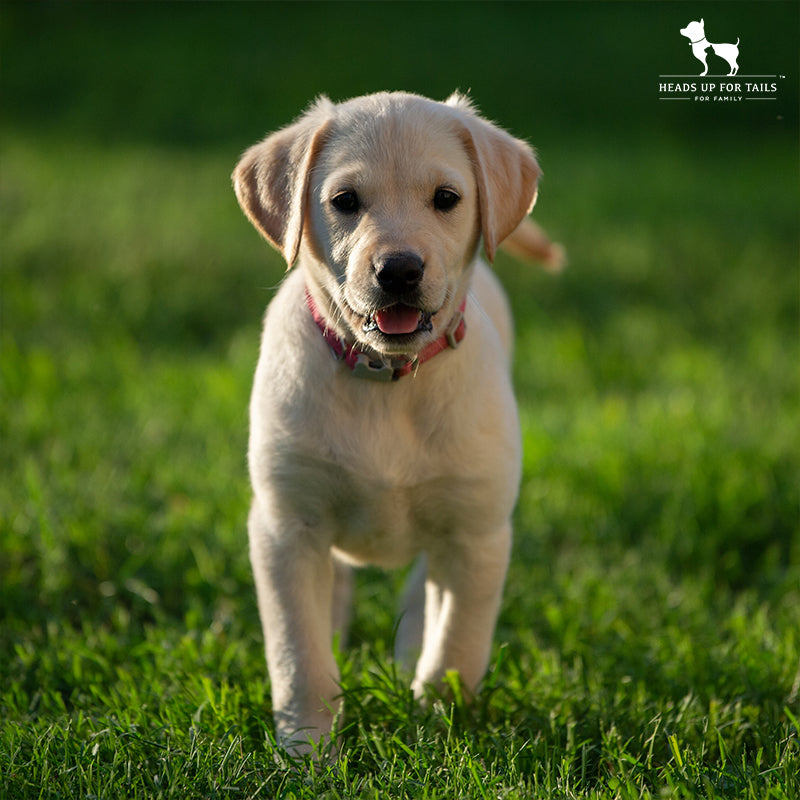

In [ ]:
from IPython.display import display
display(image)


## 11) Exercises (Try It Yourself)



1) **Zero‑Shot Labels:** Change `candidate_labels` in Section 2 (e.g., ["how‑to", "billing", "outage", "praise"]).  
2) **Domain Shift:** Paste your own domain text into QA / Summarization; compare outputs.  
3) **Model Cards:** In the Hub, open the model page used by a pipeline (e.g., `facebook/bart-large-mnli`). Skim the **Model Card** for intended use & limitations.  
4) **Batching:** Time single‑input vs list‑input for sentiment. Which is faster?  
5) **Multilingual:** Try `xlm-roberta-large` with NER or zero‑shot and test on non‑English text.



## 12) Troubleshooting Tips



- **Downloads are slow / blocked:** Pre‑download models or set a local HF cache (`HF_HOME`).  
- **Out of memory:** Use smaller models (e.g., `distilbert-base-uncased`), smaller `max_length`, or switch to CPU.  
- **Mismatched mask token:** For `fill-mask`, ensure your input uses the right mask (e.g., `[MASK]` for BERT).  
- **Reproducibility:** Generation may vary slightly; set seeds and keep sequences short in demos.
